In [ ]:
from google.colab import files
files.upload()

In [25]:
import numpy as np
import pandas as pd

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv("wage.csv", sep=";")
data["date"] = pd.to_datetime(data["date"], format="%d.%m.%Y")
data.set_index("date", inplace=True)

In [16]:
data.tail()

,wage
date,
2020-08-01,47649
2020-09-01,49259
2020-10-01,49539
2020-11-01,49274
2020-12-01,69278


In [77]:
train_data = data[:63] # 75% train
test_data = data[63:]  # 25% test

##Применение библиотеки

In [38]:
fitted_model = ExponentialSmoothing(train_data['wage'],
                                    trend='mul', seasonal='mul',
                                    seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(21).rename('forecast')

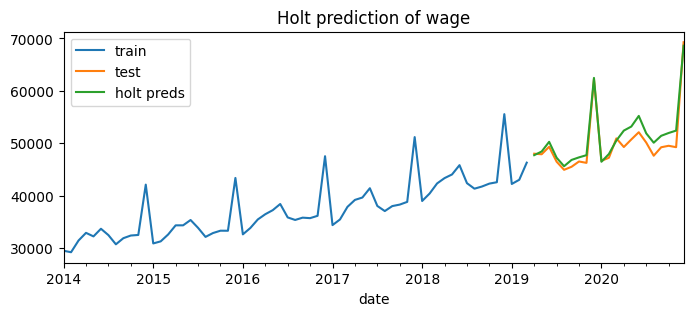

In [42]:
train_data['wage'].plot(legend=True, label='train')
test_data['wage'].plot(legend=True, label='test', figsize=(8, 3))
test_predictions.plot(legend=True, label='holt preds')
                      #xlim=['2019-04-01', '2020-12-01'])
plt.title('Holt prediction of wage')
plt.show()

In [41]:
print(f'Mean Absolute Error = {mean_absolute_error(test_data, test_predictions)}')
print(f'Mean Squared Error = {mean_squared_error(test_data, test_predictions)}')

Mean Absolute Error = 1413.4968923534184
Mean Squared Error = 3022553.238926118


In [43]:
model = ExponentialSmoothing(data['wage'], trend='mul',
                             seasonal='mul', seasonal_periods=12).fit()
holt_preds = model.forecast(steps=21)

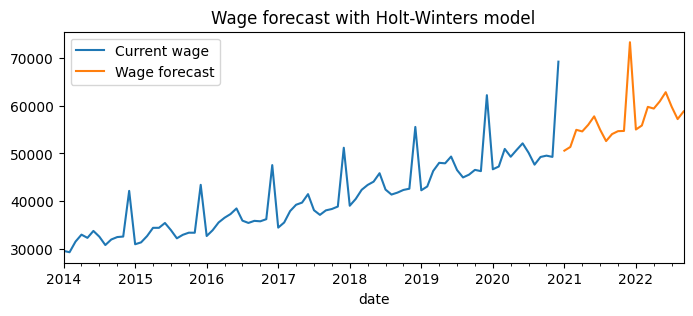

In [45]:
data['wage'].plot(figsize=(8, 3),legend=True,
                  label='Current wage')
holt_preds.plot(legend=True, label='Wage forecast')
plt.title('Wage forecast with Holt-Winters model');
plt.show()

##Реализация

In [93]:
series = train_data['wage'].values

In [94]:
len(series)

63

In [81]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

In [95]:
# the average of trend averages across seasons
initial_trend(series, 12)

115.27083333333333

In [83]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [96]:
initial_seasonal_components(series, 12)

{0: -3879.5333333333338,
 1: -3113.5333333333338,
 2: -1213.7333333333336,
 3: 93.26666666666642,
 4: 343.2666666666664,
 5: 1781.8666666666663,
 6: -634.1333333333336,
 7: -1830.7333333333336,
 8: -1091.3333333333335,
 9: -750.1333333333336,
 10: -485.93333333333356,
 11: 10780.666666666668}

In [85]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [117]:
for alpha in [0.1, 0.5, 0.7]:
  for beta in [0.01, 0.02, 0.03]:
    for gamma in [0.7, 0.8, 0.9]:
      hw_preds = triple_exponential_smoothing(series, 12, alpha, beta, gamma, 21)
      mae = mean_absolute_error(test_data['wage'].values, hw_preds[63:])
      print(f"alpha:{alpha} beta:{beta} gamma:{gamma} error:{mae}")

alpha:0.1 beta:0.01 gamma:0.7 error:2661.683378445026
alpha:0.1 beta:0.01 gamma:0.8 error:2634.1670818967764
alpha:0.1 beta:0.01 gamma:0.9 error:2616.3133338762577
alpha:0.1 beta:0.02 gamma:0.7 error:2155.383377000315
alpha:0.1 beta:0.02 gamma:0.8 error:2153.8149723543124
alpha:0.1 beta:0.02 gamma:0.9 error:2160.7857660917985
alpha:0.1 beta:0.03 gamma:0.7 error:1781.0825180063027
alpha:0.1 beta:0.03 gamma:0.8 error:1796.3189472441106
alpha:0.1 beta:0.03 gamma:0.9 error:1819.98890894036
alpha:0.5 beta:0.01 gamma:0.7 error:1756.1697449932115
alpha:0.5 beta:0.01 gamma:0.8 error:1816.7879410051896
alpha:0.5 beta:0.01 gamma:0.9 error:1857.5423283739397
alpha:0.5 beta:0.02 gamma:0.7 error:1308.0944401420336
alpha:0.5 beta:0.02 gamma:0.8 error:1364.1867921844273
alpha:0.5 beta:0.02 gamma:0.9 error:1400.318083435264
alpha:0.5 beta:0.03 gamma:0.7 error:1134.3298672545532
alpha:0.5 beta:0.03 gamma:0.8 error:1157.2933224140395
alpha:0.5 beta:0.03 gamma:0.9 error:1184.4501250809224
alpha:0.7 beta:

In [97]:
hw_preds = triple_exponential_smoothing(series, 12, 0.716, 0.029, 0.993, 21)

In [110]:
mean_absolute_error(test_data['wage'].values, hw_preds[63:])

1099.4952622575129

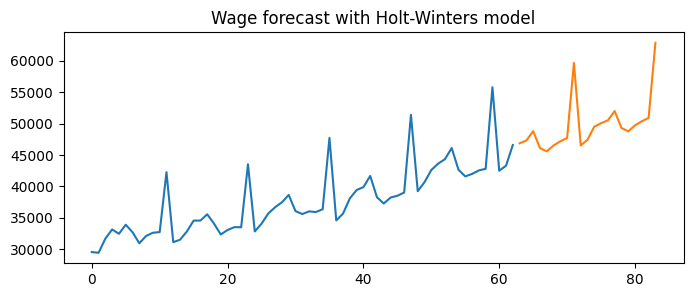

In [116]:
plt.figure(figsize=(8, 3))
plt.plot(hw_preds[:63], label='Current wage')
plt.plot(list(range(63, 63+21)), hw_preds[63:], label='Wage forecast')
plt.title('Wage forecast with Holt-Winters model');
plt.show()